In [ ]:
# Convert the pdf raw files into images and make annotations using LabelMe
# Make mask files

In [ ]:
# 0. The environment prerequisites:
!pip install pdf2image
# install poppler

# !pip install labelme # use labelme to make annotations, I use Windows to finish this step
# But other steps are finished in Ubuntu22 (WSL2)

In [ ]:
# 1. Convert the pdf raw files into images and make annotations using LabelMe

import os
import glob
from pdf2image import convert_from_path

pdf_folder = "data/raw"
output_root = "data/convert_image"
os.makedirs(output_root, exist_ok=True)

pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))
print("Found PDF files:", pdf_files)

dpi_value = 300

for pdf_file in pdf_files:
    print(f"\nConverting: {pdf_file}")
    base_name = os.path.splitext(os.path.basename(pdf_file))[0]

    pdf_output_dir = os.path.join(output_root, base_name)
    os.makedirs(pdf_output_dir, exist_ok=True)
    
    # LOAD PAGE ONE BY ONE, LOWER CONSUMPTION OF PERFORMANCE
    chunk_size = 10
    start_page = 1
    end_page = chunk_size

    # 6.pdf is too large for 300 dpi
    if base_name == "6":  # Use 150 DPI for 6.pdf
        dpi_value = 150
    else:  # Keep 300 DPI for 1.pdf-5.pdf
        dpi_value = 300

    while True:
        pages = convert_from_path(pdf_file, dpi=dpi_value,
                                  first_page=start_page,
                                  last_page=end_page)

        if not pages:
            break

        # SAVE PAGE ONE BY ONE
        for i, page in enumerate(pages, start=start_page):
            out_path = os.path.join(pdf_output_dir, f"{base_name}_page_{i:03d}.png")
            page.save(out_path, "PNG")
            print(f"  Saved: {out_path}")

        # GOING TO NEXT PAGE
        start_page = end_page + 1
        end_page += chunk_size

print("\nCONVERTING SUCCESSFULLY.")

# The annotations are made by LabelMe
# Annotation files are stored in src/data/annotation
# Annotation way screenshots are stored in docs/annotation


In [ ]:
import os
import json
import cv2
import numpy as np

def generate_masks_with_debug(img_dir, label_dir, mask_dir, resize=None):
    """
    根据 label_dir 中的 JSON 标注文件，读取对应的图片并生成二值掩码 (0/1)，
    将生成的掩码以 .png 文件保存到 mask_dir。
    
    带有详细的调试打印信息，帮助排查为什么可能出现全黑或读不到图等问题。
    
    参数：
    - img_dir : 图片所在目录，例如 data/annotation_images/
    - label_dir : JSON 标注文件所在目录，例如 data/annotation_labels/
    - mask_dir : 生成的 mask 文件要保存到哪个目录，例如 data/mask/
    - resize  : (width, height)，可选。如果不为 None，则会把 mask 用最近邻插值
                resize 到该尺寸后再保存。若想保持原尺寸，则传 None。
    """
    # 如果 mask_dir 不存在，则创建
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)
    
    # 遍历所有 JSON 文件
    for filename in os.listdir(label_dir):
        if filename.lower().endswith('.json'):
            json_path = os.path.join(label_dir, filename)
            base_name = filename[:-5]  # 去掉 ".json" 后缀

            # 假设图片后缀是 .png，如 "1_page_001.json" -> "1_page_001.png"
            # 如果你的图片是 .jpg，请自行修改这里
            image_name = base_name + '.png'
            image_path = os.path.join(img_dir, image_name)

            print(f"\n===== Processing {filename} =====")
            print(f"JSON path:  {json_path}")
            print(f"Image path: {image_path}")

            # 1. 检查对应的图片文件是否存在
            if not os.path.exists(image_path):
                print(f"[WARNING] Could not find corresponding image for JSON: {filename}")
                continue

            # 2. 读取图片
            img = cv2.imread(image_path)
            if img is None:
                print(f"[WARNING] Could not read image: {image_path}")
                continue
            h, w = img.shape[:2]
            print(f"Image size: width={w}, height={h}")

            # 3. 创建空白 mask
            mask = np.zeros((h, w), dtype=np.uint8)

            # 4. 打开 JSON 文件，读取 shapes
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            shapes = data.get('shapes', [])
            print(f"Number of shapes in JSON: {len(shapes)}")

            # 5. 遍历 shapes，检查 label 和 points
            for i, shape in enumerate(shapes):
                label = shape.get('label', '')
                points = shape.get('points', [])

                print(f"  - Shape {i}, label='{label}', #points={len(points)}")
                # 如果你的标注里 label 大小写不统一，可以考虑 label.lower() == 'text'
                if label == 'text':
                    pts = np.array(points, dtype=np.int32)
                    if pts.size == 0:
                        print("    [DEBUG] No points found in this shape, skip.")
                        continue

                    # 调试：看一下多边形顶点的范围
                    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
                    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
                    print(f"    [DEBUG] Polygon bounding box: x=[{x_min}, {x_max}], y=[{y_min}, {y_max}]")

                    # 如果多边形超出图像范围，fillPoly 可能画不到任何像素
                    if x_min < 0 or x_max >= w or y_min < 0 or y_max >= h:
                        print("    [WARNING] Polygon is partially/fully out of image bounds.")

                    # 填充多边形区域为1
                    cv2.fillPoly(mask, [pts], 1)

            # 检查一下有多少像素被填成1
            filled_pixels = np.count_nonzero(mask)
            print(f"[INFO] Filled {filled_pixels} pixels in mask for {filename}.")

            # 6. 如果需要 resize，就做最近邻插值
            if resize is not None:
                mask = cv2.resize(mask, resize, interpolation=cv2.INTER_NEAREST)
                print(f"[INFO] Mask resized to {resize}")

            # 7. 保存 mask
            mask_filename = base_name + '_mask.png'
            mask_path = os.path.join(mask_dir, mask_filename)
            cv2.imwrite(mask_path, mask)
            print(f"[INFO] Saved mask to {mask_path}")
            print(f"Mask min={mask.min()}, max={mask.max()}")
            print("====================================")


# ========== 你可以在 Notebook 中运行下面这段 ==========

if __name__ == "__main__":
    # 根据你的实际路径修改
    img_dir = "data/annotation_images"    # 图片目录
    label_dir = "data/annotation_labels"  # JSON 标注目录
    mask_dir = "data/mask"               # 输出掩码目录

    # 是否需要统一 resize 掩码？如果想保持原图大小，就传 None
    resize_dim = None  # (224, 224) 或 None

    generate_masks_with_debug(
        img_dir=img_dir,
        label_dir=label_dir,
        mask_dir=mask_dir,
        resize=resize_dim
    )
    print("\n所有掩码生成完毕！\n")



--- Visualizing data/annotation_images/3_page_001.png with data/mask/3_page_001_mask.png ---


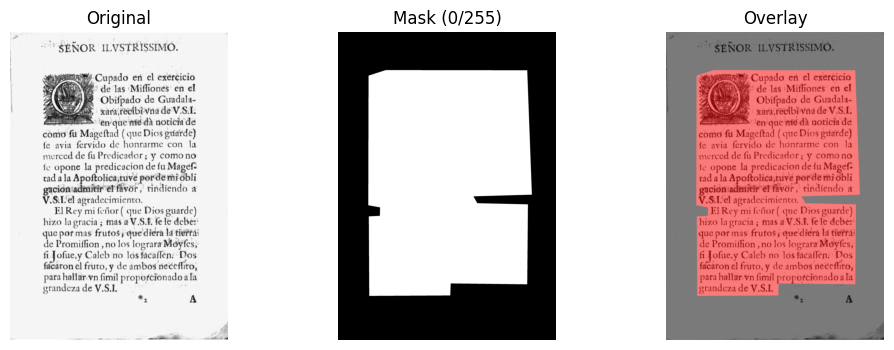


--- Visualizing data/annotation_images/4_page_001.png with data/mask/4_page_001_mask.png ---


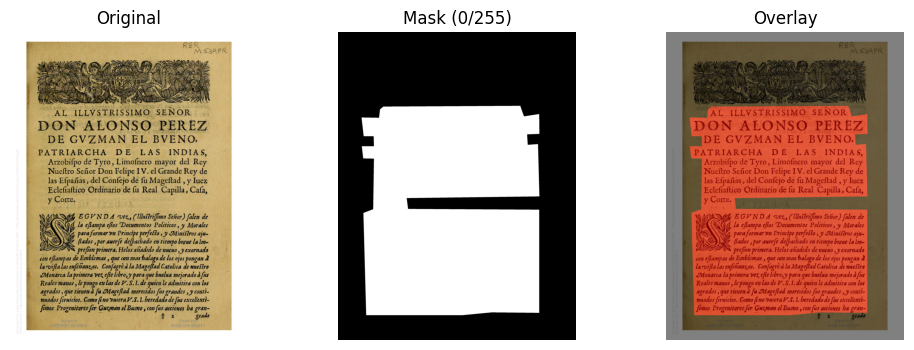


--- Visualizing data/annotation_images/1_page_002.png with data/mask/1_page_002_mask.png ---


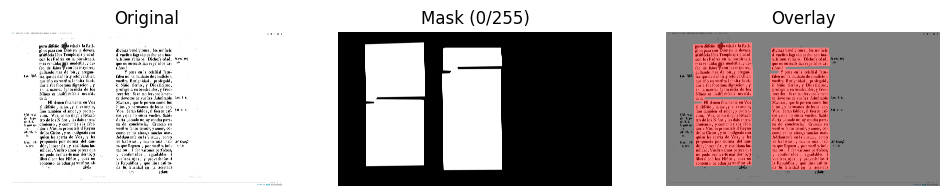

In [1]:
# Test mask (0和1本身差别不大，所以看不出来区别)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_masks(img_dir="data/annotation_images",
               mask_dir="data/mask",
               image_names=None):
    """
    读取指定的图像与对应的掩码文件，并做可视化。
    - 原图
    - 掩码(灰度)
    - 叠加效果(半透明)
    
    参数:
    - img_dir : 原图目录
    - mask_dir: 掩码目录
    - image_names: 要可视化的图像文件列表（不含 _mask 后缀）。
                   如果为 None，则自动从 img_dir 里取前3张 .png。
    """
    
    # 如果用户没有手动指定 image_names，则从目录中取前三张
    if image_names is None:
        all_imgs = sorted([f for f in os.listdir(img_dir) 
                           if f.lower().endswith('.png')])
        # 只取前3个作为演示
        image_names = all_imgs[:3]
    else:
        # 如果用户传进来的是 ["3_page_001.png", "4_page_001.png", ...]
        # 就直接用它们
        pass
    
    for fname in image_names:
        # 如果传进来的 fname 里包含 .png，就把后缀去掉
        base_name = fname.rsplit('.', 1)[0]
        
        img_path  = os.path.join(img_dir,  base_name + '.png')
        mask_path = os.path.join(mask_dir, base_name + '_mask.png')
        
        print(f"\n--- Visualizing {img_path} with {mask_path} ---")
        
        # 1) 读取原图 (BGR -> RGB)
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            print(f"[Error] Cannot read image: {img_path}, skip.")
            continue
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # 2) 读取掩码 (灰度)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask_gray is None:
            print(f"[Error] Cannot read mask: {mask_path}, skip.")
            continue
        
        # mask_gray 可能是 0/255 或 0/1，如果是 0/1，显示会很暗
        # 为了可视化，我们把它转成 0/255
        # 只要非0都视为1
        mask_bin = (mask_gray > 0).astype(np.uint8)  # 0或1
        mask_vis = (mask_bin * 255).astype(np.uint8) # 0或255
        
        # 3) 生成叠加效果 (半透明红色)
        #   - 先把原图和一个"红色蒙版"做加权混合
        alpha = 0.5  # 半透明程度
        # 构造一个纯红色画布(与 image 同尺寸)
        colored_mask = np.zeros_like(image)
        colored_mask[..., 0] = 255  # 这里是RGB模式，(255,0,0)就是纯红
        # 但是OpenCV中通道顺序是BGR，如果想在cv2.addWeighted里保持一致，需要注意
        # 这里我们后面不用cv2.cvtColor，所以可以直接把R分量赋值
        
        # 只在mask_bin=1的地方保留红色
        # 在其他地方置为0 (黑)
        colored_mask[mask_bin == 0] = (0,0,0)
        
        # 用 addWeighted 实现 alpha blend
        # 注意：image是uint8的RGB，colored_mask也是uint8
        overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)
        
        # 4) 可视化显示 (原图, 纯mask, 叠加效果)
        plt.figure(figsize=(12, 4))
        
        # (a) 原图
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Original")
        plt.axis('off')
        
        # (b) 掩码
        plt.subplot(1,3,2)
        plt.imshow(mask_vis, cmap='gray')
        plt.title("Mask (0/255)")
        plt.axis('off')
        
        # (c) 叠加图
        plt.subplot(1,3,3)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis('off')
        
        plt.show()


# ========== Notebook中测试示例 ==========

if __name__ == "__main__":
    # 假设目录如下:
    # data/
    #   ├ annotation_images/  (如: 3_page_001.png)
    #   └ mask/               (如: 3_page_001_mask.png)
    
    img_dir  = "data/annotation_images"
    mask_dir = "data/mask"
    
    # 指定想看的图像文件(不含 _mask 的那种), 
    # 例如你想看: "3_page_001.png", "4_page_001.png", "1_page_002.png"
    sample_files = [
        "3_page_001.png",
        "4_page_001.png",
        "1_page_002.png"
    ]
    
    # 调用可视化函数
    test_masks(
        img_dir=img_dir,
        mask_dir=mask_dir,
        image_names=sample_files
    )


1_page_001_mask.png => unique pixel values: [0 1]
  shape=(6000, 10667), total=64002000, zeros=53918870, ones=10083130, others=0


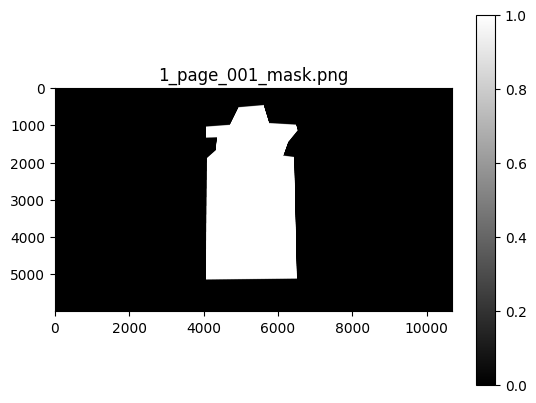

1_page_002_mask.png => unique pixel values: [0 1]
  shape=(6000, 10667), total=64002000, zeros=42687805, ones=21314195, others=0


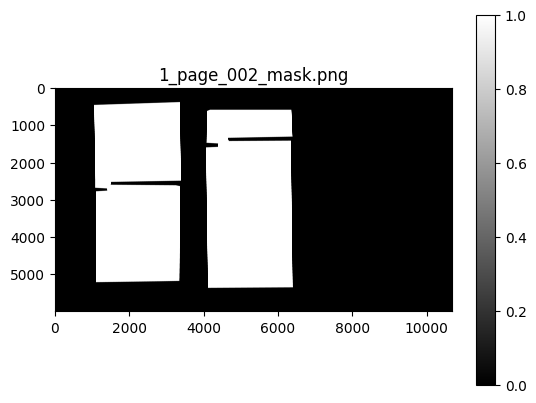

1_page_003_mask.png => unique pixel values: [0 1]
  shape=(6000, 10667), total=64002000, zeros=49314888, ones=14687112, others=0


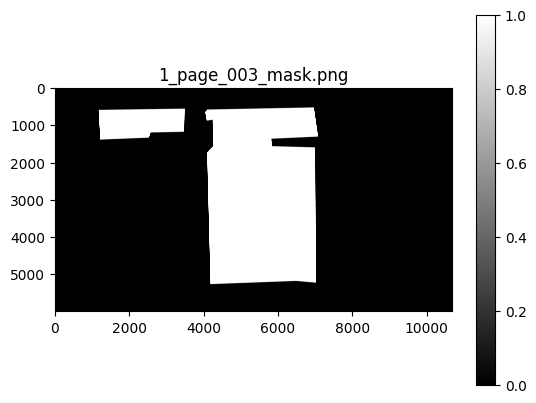

2_page_001_mask.png => unique pixel values: [0 1]
  shape=(3253, 2472), total=8041416, zeros=3134379, ones=4907037, others=0


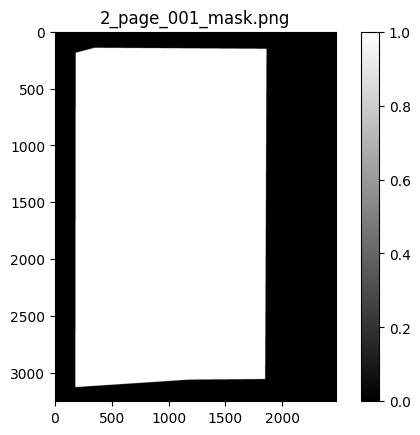

2_page_002_mask.png => unique pixel values: [0 1]
  shape=(3216, 2419), total=7779504, zeros=4964728, ones=2814776, others=0


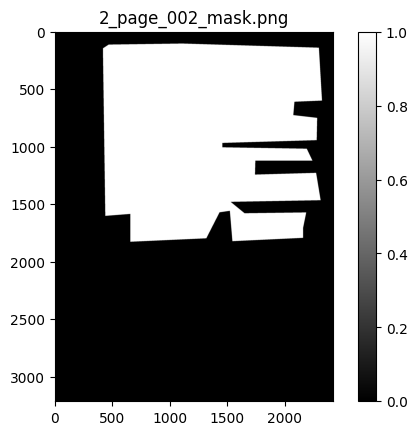

2_page_003_mask.png => unique pixel values: [0 1]
  shape=(3248, 2463), total=7999824, zeros=2930910, ones=5068914, others=0


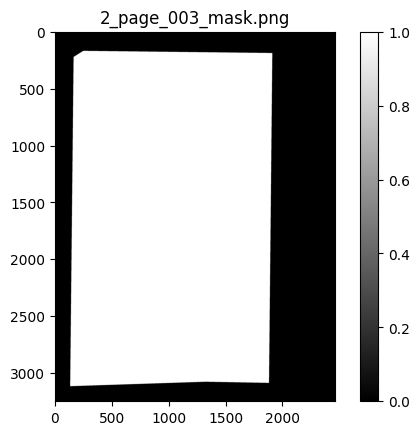

3_page_001_mask.png => unique pixel values: [0 1]
  shape=(3508, 2481), total=8703348, zeros=4219131, ones=4484217, others=0


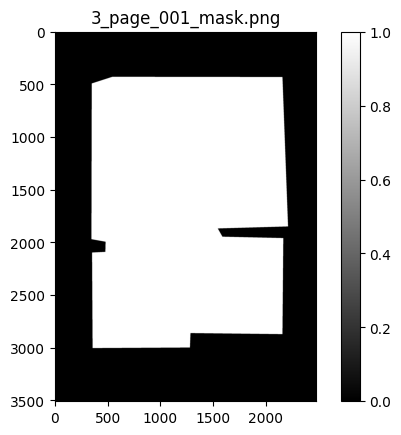

3_page_002_mask.png => unique pixel values: [0 1]
  shape=(3508, 2481), total=8703348, zeros=3336422, ones=5366926, others=0


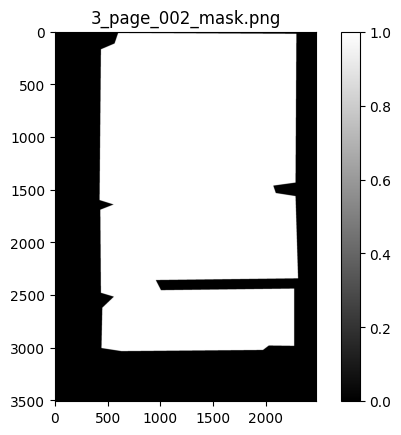

3_page_003_mask.png => unique pixel values: [0 1]
  shape=(3508, 2481), total=8703348, zeros=3627469, ones=5075879, others=0


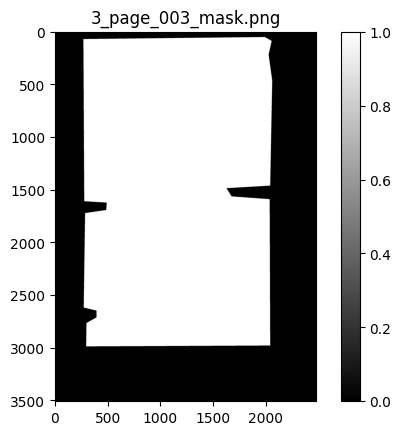

4_page_001_mask.png => unique pixel values: [0 1]
  shape=(3301, 2550), total=8417550, zeros=4541804, ones=3875746, others=0


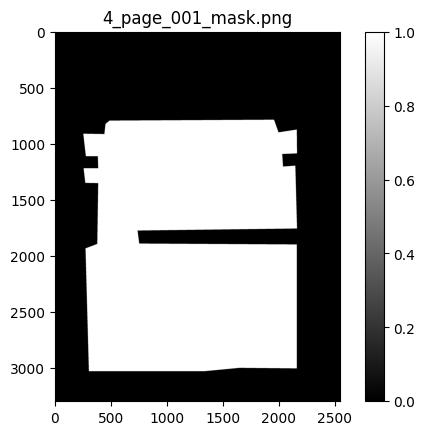

4_page_002_mask.png => unique pixel values: [0 1]
  shape=(3301, 2550), total=8417550, zeros=6534741, ones=1882809, others=0


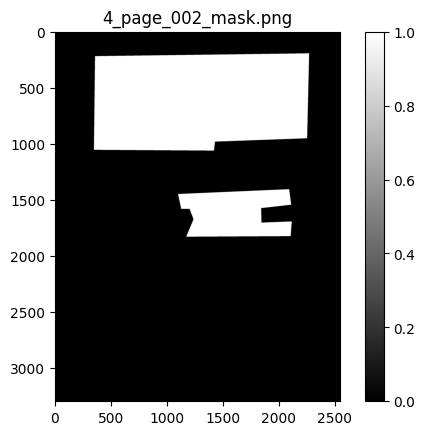

4_page_003_mask.png => unique pixel values: [0 1]
  shape=(3301, 2550), total=8417550, zeros=4684509, ones=3733041, others=0


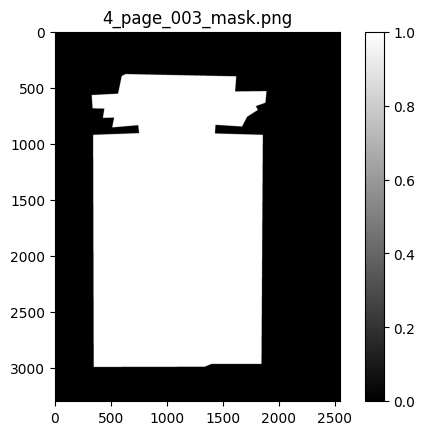

5_page_001_mask.png => unique pixel values: [0 1]
  shape=(8825, 6225), total=54935625, zeros=15980718, ones=38954907, others=0


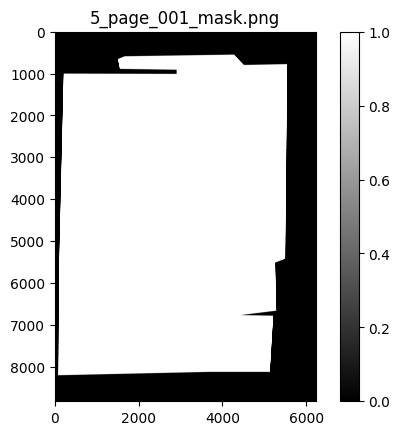

5_page_002_mask.png => unique pixel values: [0 1]
  shape=(8863, 6307), total=55898941, zeros=19170358, ones=36728583, others=0


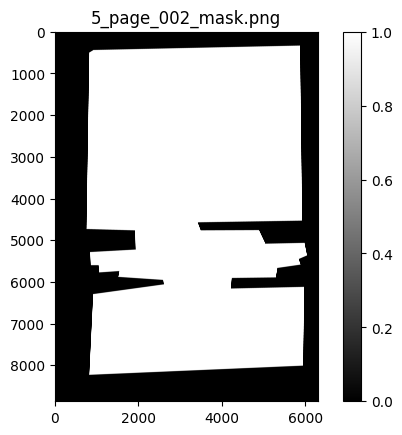

5_page_003_mask.png => unique pixel values: [0 1]
  shape=(8825, 6163), total=54388475, zeros=15219469, ones=39169006, others=0


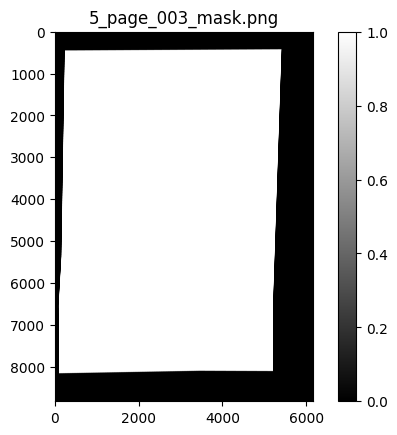

6_page_001_mask.png => unique pixel values: [0 1]
  shape=(8400, 6300), total=52920000, zeros=38109705, ones=14810295, others=0


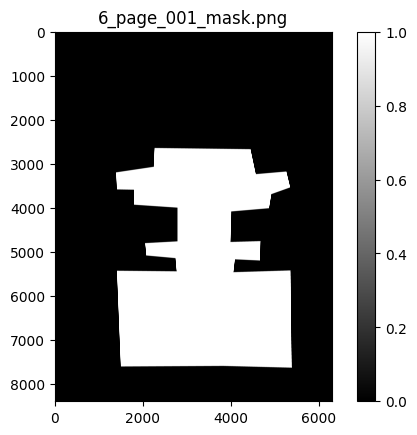

6_page_002_mask.png => unique pixel values: [0 1]
  shape=(8400, 6300), total=52920000, zeros=18434426, ones=34485574, others=0


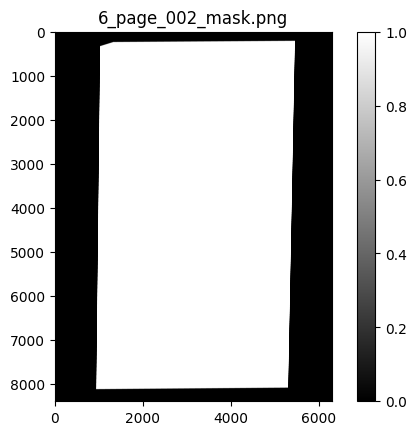

6_page_003_mask.png => unique pixel values: [0 1]
  shape=(8400, 6300), total=52920000, zeros=22811435, ones=30108565, others=0


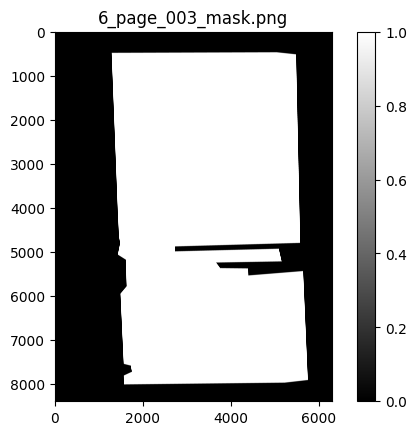

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

mask_dir = "data/mask"  # 你的掩码文件夹路径

for filename in sorted(os.listdir(mask_dir)):
    if filename.lower().endswith('.png'):
        mask_path = os.path.join(mask_dir, filename)
        
        # 读取灰度图
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            print(f"[错误] 无法读取文件: {mask_path}")
            continue
        
        # 打印唯一像素值
        unique_vals = np.unique(mask)
        print(f"{filename} => unique pixel values: {unique_vals}")
        
        # 统计 0, 1, 其他值 个数
        zero_count = np.count_nonzero(mask == 0)
        one_count = np.count_nonzero(mask == 1)
        total_pixels = mask.size
        other_count = total_pixels - zero_count - one_count
        
        print(f"  shape={mask.shape}, total={total_pixels}, zeros={zero_count}, ones={one_count}, others={other_count}")
        
        # 如果你只关心是否全是0或1(或255), 也可额外做个提示:
        # allowed_set = {0,1,255}
        # actual_set = set(unique_vals.tolist())
        # if not actual_set.issubset(allowed_set):
        #     print(f"  [警告] 存在非 0/1/255 的像素值: {actual_set - allowed_set}")
        
        # 可视化掩码
        plt.figure()
        plt.title(filename)
        # 如果掩码是 0/1，可以设置 vmin=0, vmax=1，让色阶只在[0,1]范围
        # 如果是0/255，可以用 vmin=0, vmax=255
        plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
